In [1]:
import sys
import os
sys.path.append("../../src")
sys.path.append("../../data")
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from IPython import display
import pylab as pl

from WSMBSS import *
from general_utils import *
from visualization_utils import * 

import warnings
warnings.filterwarnings("ignore")

notebook_name = 'Image Separation'

# np.random.seed(250)

In [2]:
image_paths = '../../data/TestImages'
images = []
for im_dir in os.listdir(image_paths):
    try:
        images.append(mpimg.imread(os.path.join(image_paths,im_dir)))
    except:
        pass
images = np.array(images)

In [3]:
image_height_and_width = [454, 605]
small_images = np.zeros((images.shape[0],image_height_and_width[0]* image_height_and_width[1]* 3))
small_to_large_image_size_ratio = 0.15
for i in range(images.shape[0]):
    small_img = cv2.resize(images[i], # original image
                           (0,0), # set fx and fy, not the final size
                           fx=small_to_large_image_size_ratio, 
                           fy=small_to_large_image_size_ratio, 
                           interpolation=cv2.INTER_NEAREST)
    print(small_img.shape)
    if small_img.shape[0] == 486:
        small_img = cv2.resize(small_img, (0,0), fx = 454/486, fy = 605/648)

    small_images[i] = small_img.reshape(-1,)/255

small_images.shape

(454, 605, 3)
(486, 648, 3)
(486, 648, 3)
(486, 648, 3)
(454, 605, 3)
(454, 605, 3)
(486, 648, 3)
(454, 605, 3)
(454, 605, 3)
(486, 648, 3)
(486, 648, 3)
(454, 605, 3)
(454, 605, 3)
(486, 648, 3)


(14, 824010)

<IPython.core.display.Math object>

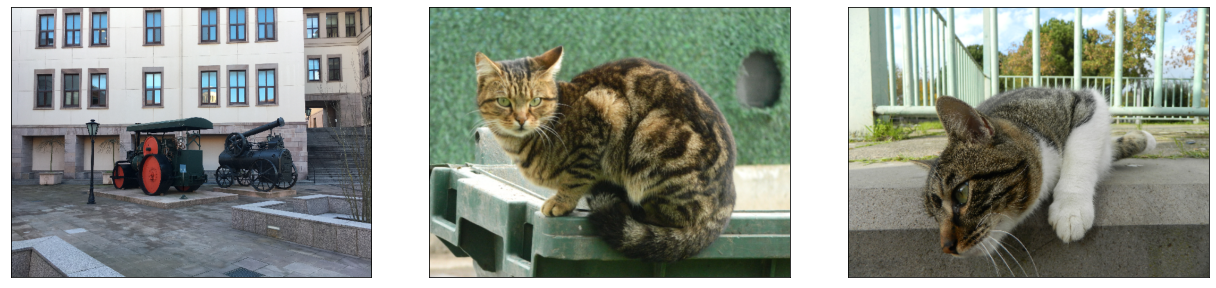

In [4]:
S = small_images[[12,6,3]]
Subplot_RGB_images(S, imsize = image_height_and_width, height = 4, width = 18)
display_matrix(np.corrcoef(S))
# plt.savefig('Original_Images.pdf', format = 'pdf', dpi = 1500)

In [5]:
np.random.seed(650)
NumberofMixtures = 5
NumberofSources = 3

A = np.random.randn(NumberofMixtures,NumberofSources)
X = np.dot(A,S)
SNR = 40

X, NoisePart = addWGN(X, SNR, return_noise=True)

SNRinp = 10 * np.log10(
    np.sum(np.mean((X - NoisePart) ** 2, axis=1))
    / np.sum(np.mean(NoisePart**2, axis=1))
)

X_ = ZeroOneNormalizeColumns(X.T).T
print("The following is the mixture matrix A")
display_matrix(A)
print("Input SNR is : {}".format(SNRinp))

print("Row standard deviation of mixtures : {}".format(X.std(1)))

The following is the mixture matrix A


<IPython.core.display.Math object>

Input SNR is : 39.998179949657654
Row standard deviation of mixtures : [0.49470436 0.68985465 0.35937612 0.38933594 0.20646696]


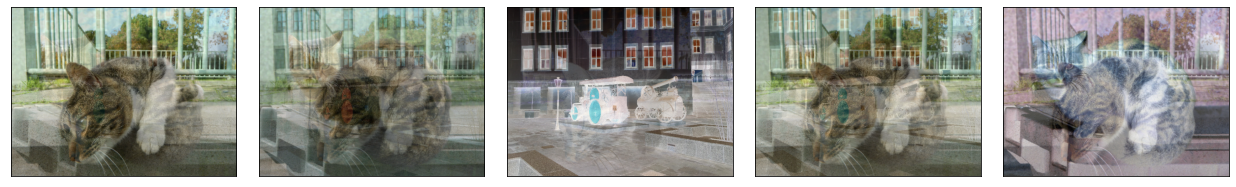

In [6]:
Subplot_RGB_images(X_, imsize = image_height_and_width, height = 3, width = 18)
# plt.savefig('Mixture_Images.pdf', format = 'pdf', dpi = 1500)

In [7]:
# subplot_1D_signals(S[:,1000:1200], title = 'Original Signals', figsize = (15.2,9), colorcode = None)

In [8]:
# plt.figure()
# plt.scatter(S[0,:], S[1,:])
# plt.figure()
# plt.scatter(S[1,:], S[2,:])
# plt.figure()
# plt.scatter(S[0,:], S[2,:])

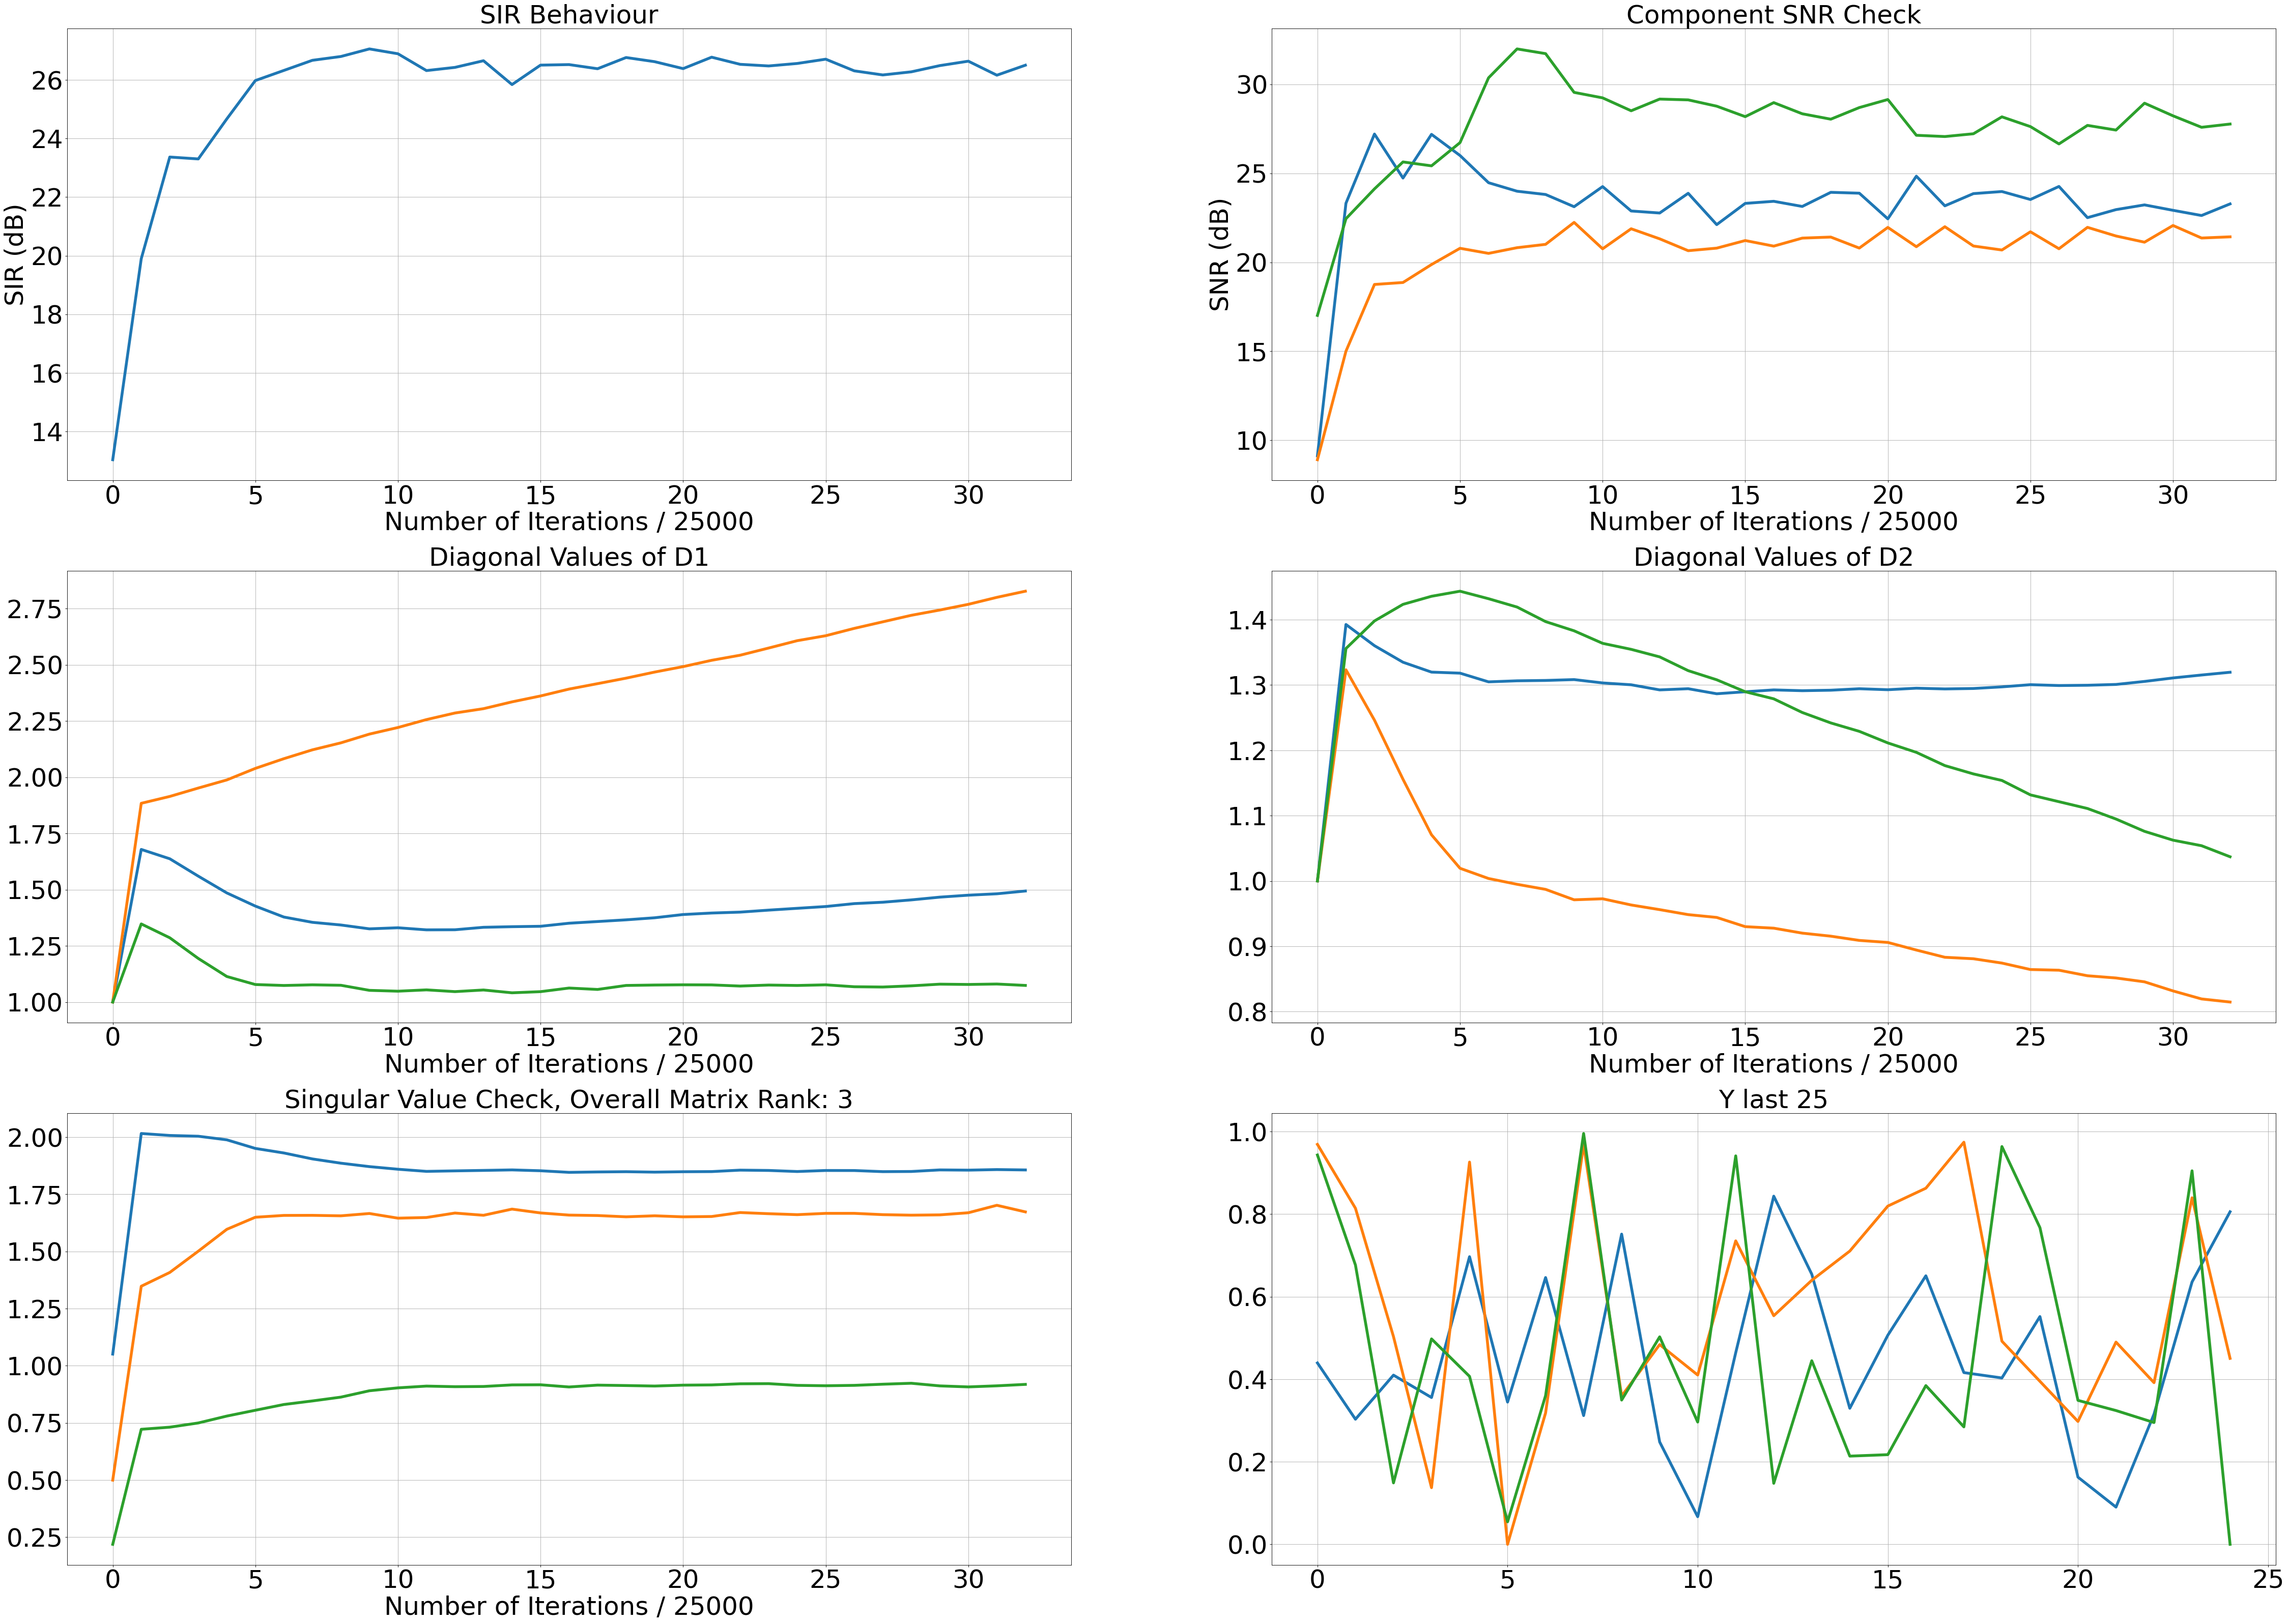

100%|██████████| 824010/824010 [05:53<00:00, 2329.78it/s]


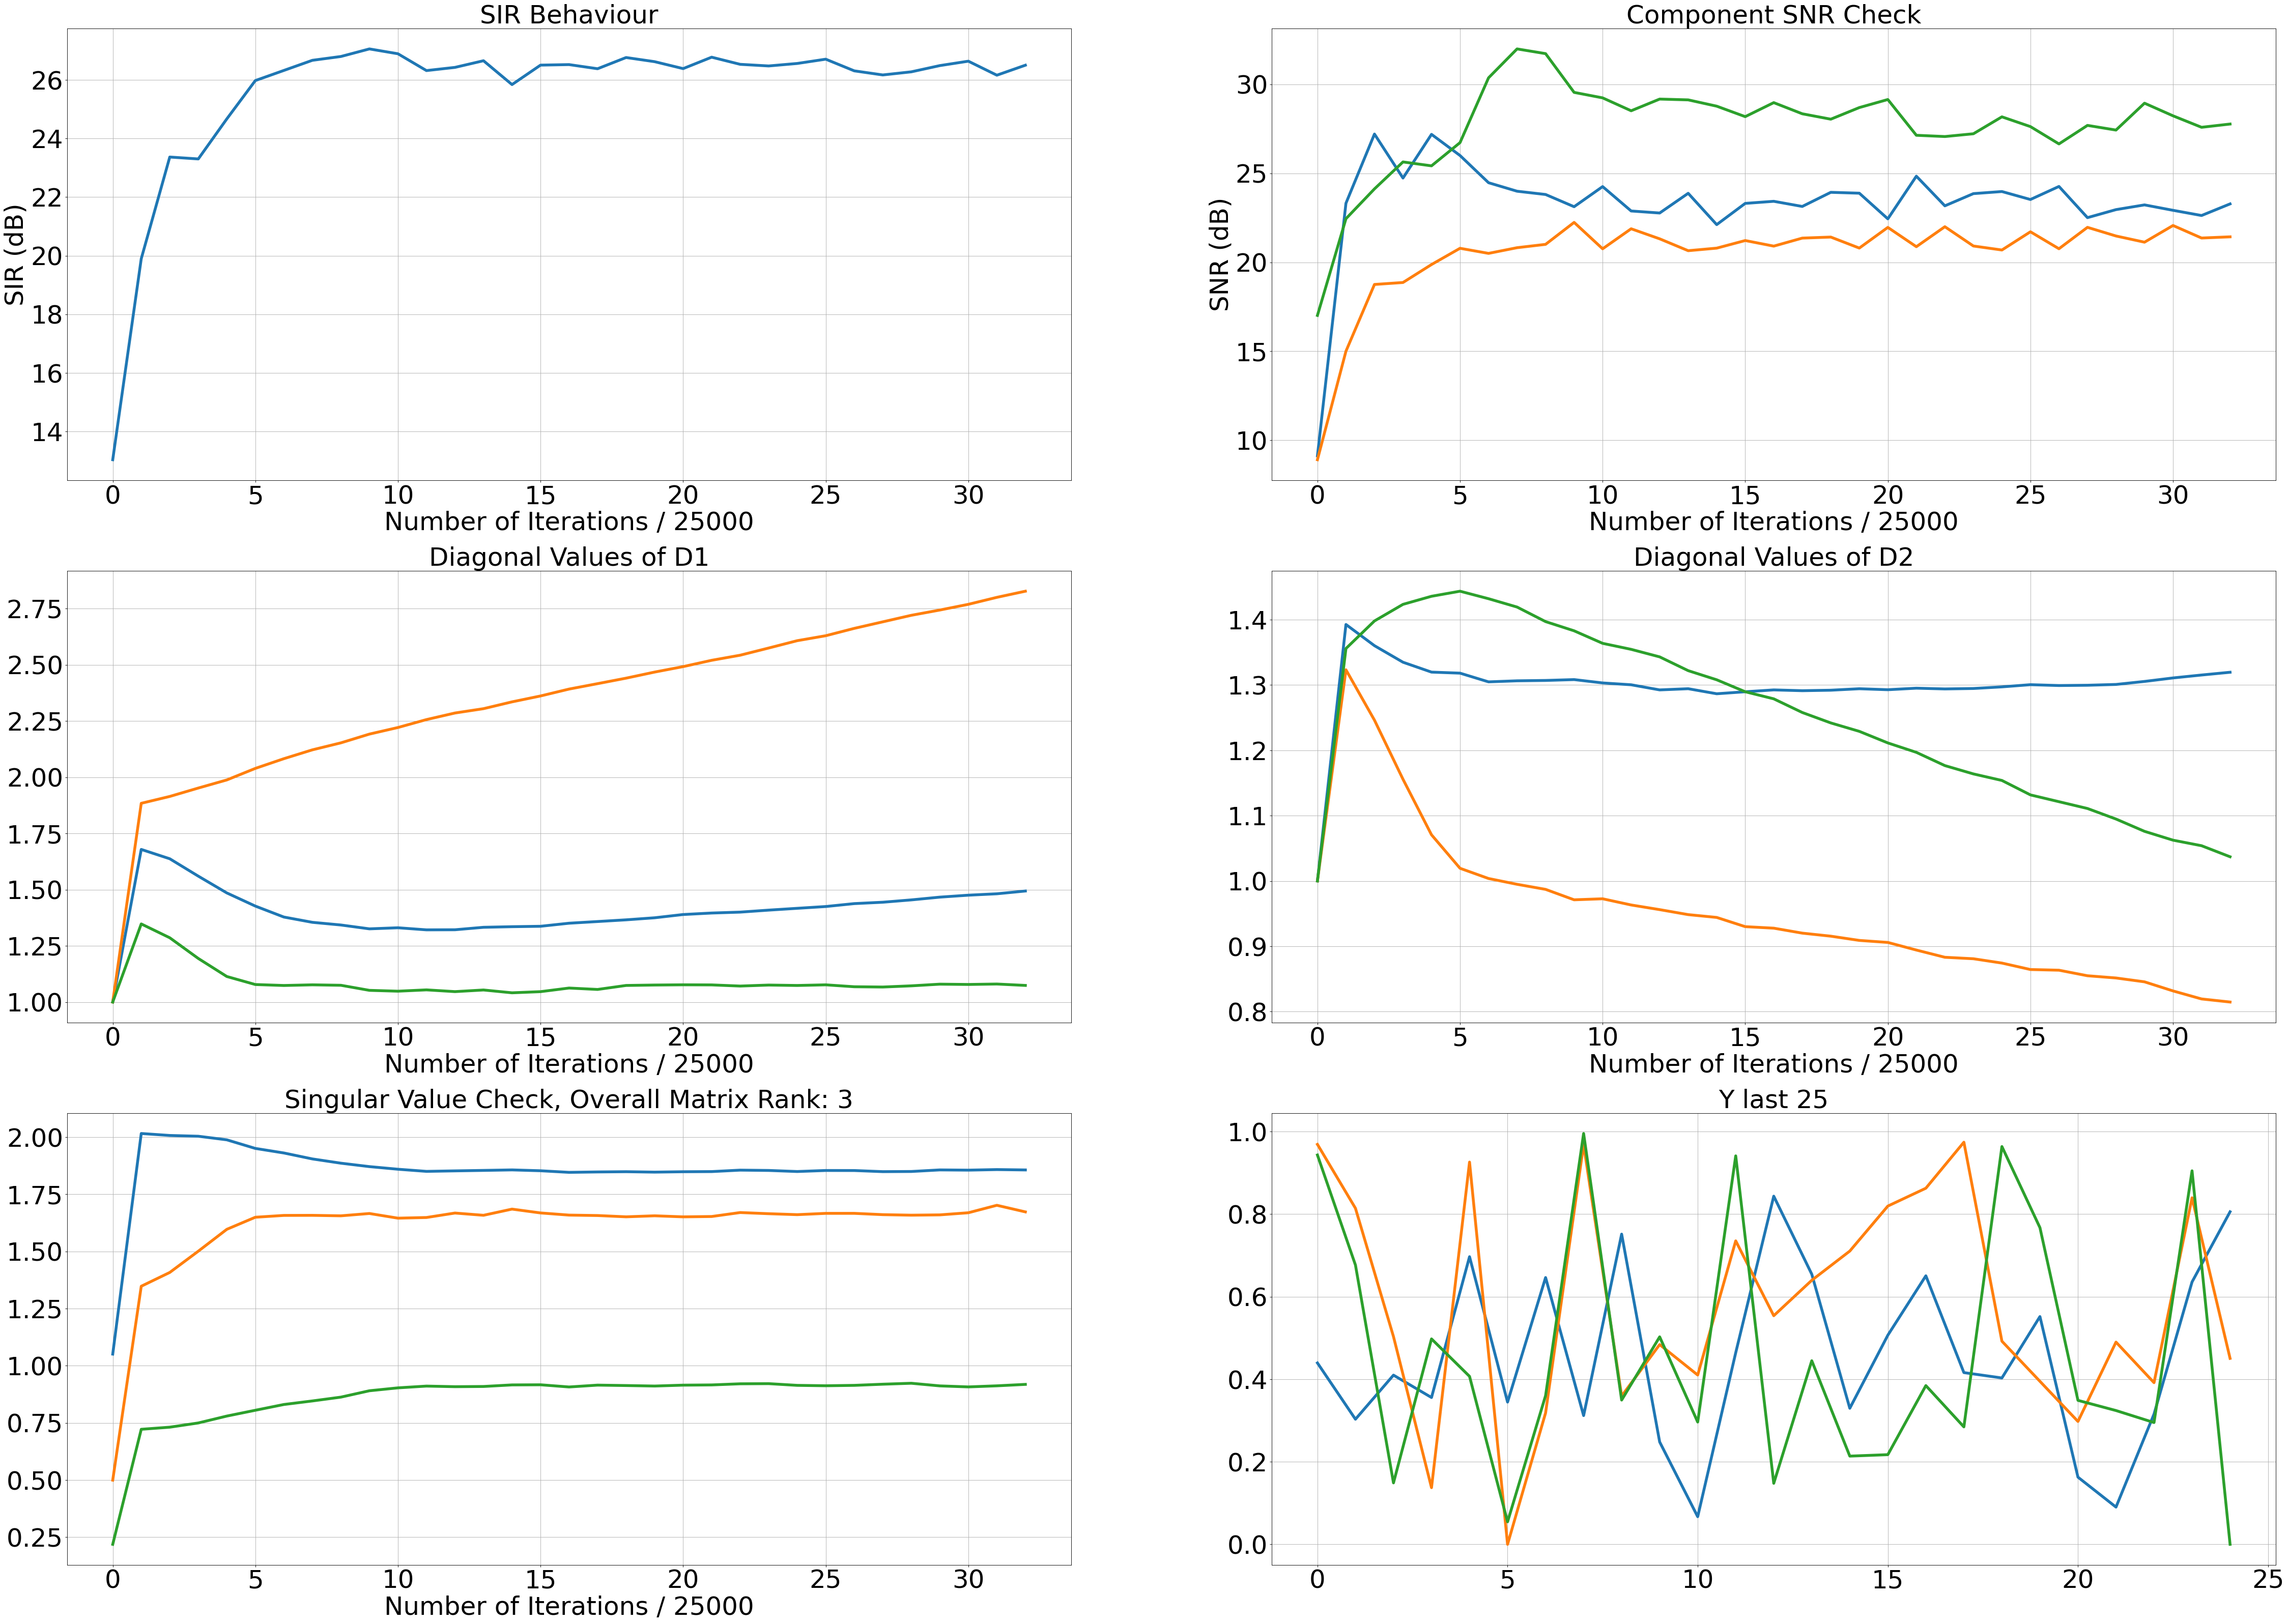

In [18]:
MUS = 0.11
gammaM_start = [MUS, MUS]
gammaM_stop = [1e-4, 1e-4]
gammaW_start = [MUS, MUS]
gammaW_stop = [1e-4, 1e-4]
OUTPUT_COMP_TOL = 1e-7
MAX_OUT_ITERATIONS= 3000
LayerGains = [1,1]
LayerMinimumGains = [1e-3,1e-3]
LayerMaximumGains = [1e6,20]
WScalings = [0.0033,0.0033]
GamScalings = [2,1]
zeta = 1*1e-5
beta = 0.5
muD = [1.125, 0.5]

s_dim = S.shape[0]
x_dim = X.shape[0]
h_dim = s_dim
samples = S.shape[1]
W_HX = np.eye(h_dim, x_dim)
W_YH = np.eye(s_dim, h_dim)
W_HX = W_HX #+ (W_HX!=0)*np.random.uniform(-0.01,0.01, size = (W_HX.shape[0], W_HX.shape[1]))
W_YH = W_YH #+ (W_YH!=0)*np.random.uniform(-0.01,0.01, size = (W_YH.shape[0], W_YH.shape[1]))
model = OnlineWSMBSS(s_dim = s_dim, x_dim = x_dim, h_dim = h_dim, 
                     gammaM_start=gammaM_start,
                     gammaM_stop=gammaM_stop,
                     gammaW_start=gammaW_start,
                     gammaW_stop=gammaW_stop, 
                     beta = beta, zeta = zeta, 
                     muD = muD,WScalings = WScalings, GamScalings = GamScalings,
                     W_HX = W_HX, W_YH = W_YH,
                     DScalings = LayerGains, LayerMinimumGains = LayerMinimumGains,
                     LayerMaximumGains = LayerMaximumGains,neural_OUTPUT_COMP_TOL = OUTPUT_COMP_TOL,
                     set_ground_truth = True, S = S, A = A)

XnoisyWSM = (0.28 * (X / X.std(1)[:,np.newaxis]))
debug_iteration_point = 25000
model.fit_batch_nnantisparse(XnoisyWSM, n_epochs = 1, 
                             neural_dynamic_iterations = 500,
                             neural_lr_start = 0.25,
                             neural_lr_stop = 0.05,
                             neural_fast_start = True,
                             debug_iteration_point = debug_iteration_point,
                             plot_in_jupyter = True,
                            )

In [19]:
Wf = model.compute_overall_mapping(return_mapping = True)
OverallMatrix = Wf @ A
perm = np.argmax(OverallMatrix, axis = 0)
Y = (Wf @ XnoisyWSM)[perm]
Y = ZeroOneNormalizeColumns(Y.T).T
PSNR_levels = []
for kk in range(S.shape[0]):
    PSNR_levels.append(psnr(S[kk], Y[kk]))

SINR = 10*np.log10(CalculateSINRjit(Y, S, False)[0])
print("Component PSNR Values : {}\n".format(PSNR_levels))
print("Overall SINR : {}".format(SINR))

Component PSNR Values : [28.62415470188531, 29.660857627070026, 31.954286341601055]

Overall SINR : 27.900659717213053


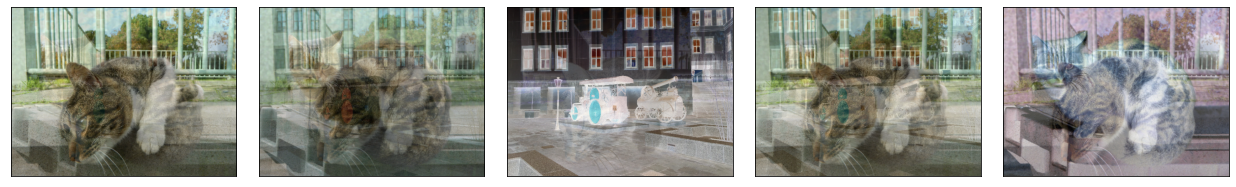

In [20]:
Subplot_RGB_images(X_, imsize = image_height_and_width, height = 3, width = 18)

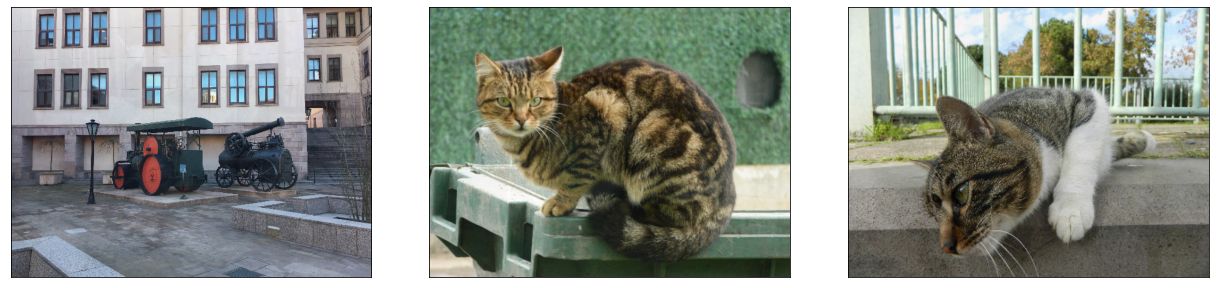

In [21]:
Subplot_RGB_images(ZeroOneNormalizeColumns(Y.T).T, imsize = image_height_and_width, height = 4, width = 18)

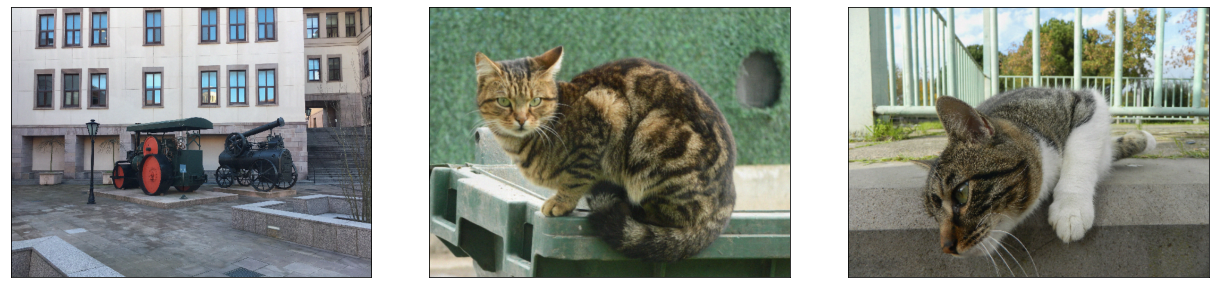

In [12]:
Subplot_RGB_images(np.clip(Y, 0,1), imsize = image_height_and_width, height = 4, width = 18)

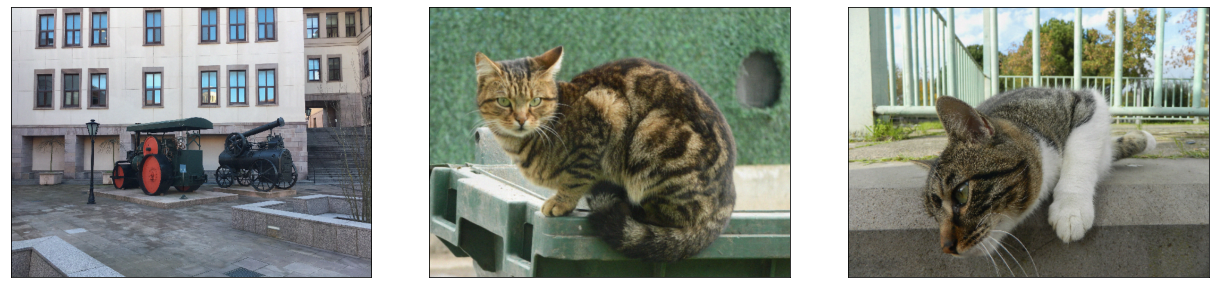

In [13]:
Subplot_RGB_images(Y, imsize = image_height_and_width, height = 4, width = 18)

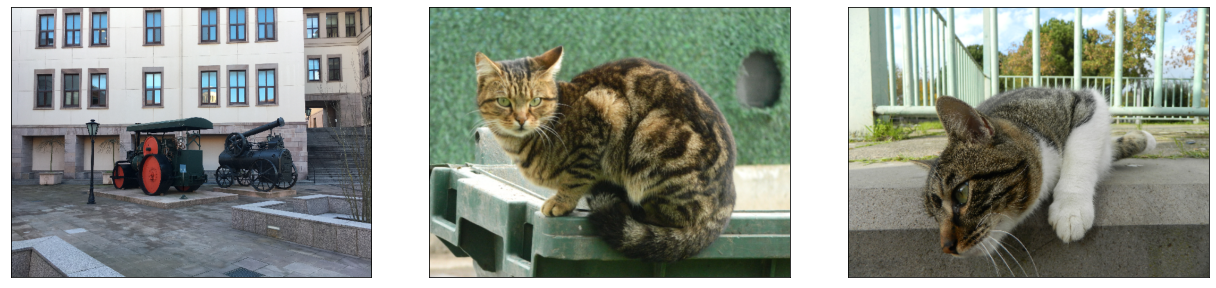

In [14]:
Subplot_RGB_images(S, imsize = image_height_and_width, height = 4, width = 18)